# atmaCup #8

## Preliminary

### Import libraries

In [ ]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pandas_profiling import ProfileReport
from matplotlib_venn import venn2 # venn図を作成する用

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.decomposition import PCA

from time import time
from typing import List
from IPython.display import clear_output

%matplotlib inline

COLOR = 'gray'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

sns.set_style()

### Load data

In [ ]:
path = '/content/drive/MyDrive/Kaggle/atmaCup8/input/'

In [ ]:
train_df = pd.read_csv(path + 'train.csv')
test_df = pd.read_csv(path + 'test.csv')

whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [ ]:
whole_df.head().T

,0,1,2,3,4
Name,LEGO Batman: The Videogame,LEGO Indiana Jones: The Original Adventures,LEGO Batman: The Videogame,Combat,LEGO Harry Potter: Years 5-7
Platform,Wii,Wii,PSP,2600,Wii
Year_of_Release,NaN,NaN,NaN,NaN,NaN
Genre,Action,Action,Action,Action,Action
Publisher,Warner Bros. Interactive Entertainment,LucasArts,Warner Bros. Interactive Entertainment,Atari,Warner Bros. Interactive Entertainment
NA_Sales,180,151,56,117,69
EU_Sales,97,61,44,7,42
JP_Sales,0,0,0,0,0
Other_Sales,28,21,27,1,12
Global_Sales,306,234,128,125,124


## Understanding Data

### Report of Train Data

In [ ]:
# report = ProfileReport(train_df)
# report

### Differences between train data and test data

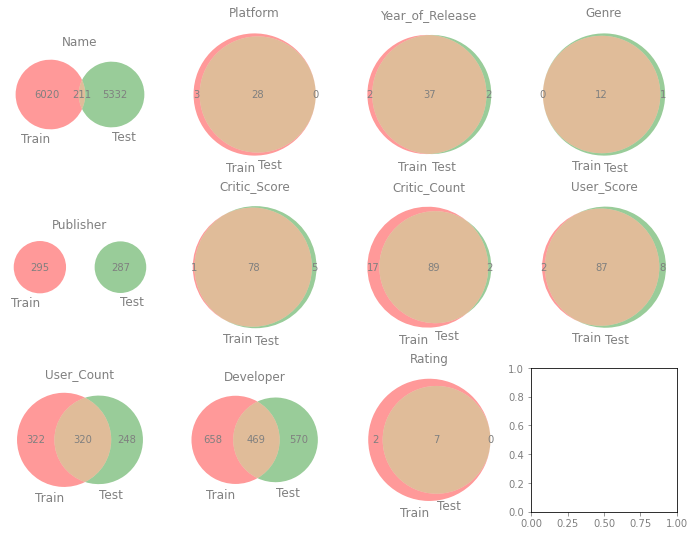

In [ ]:
columns = test_df.columns
n_figs = len(columns)
n_cols = 4
n_rows = n_figs // n_cols + 1

fig, axes = plt.subplots(figsize=(n_cols * 3, n_rows * 3), 
                         ncols=n_cols, 
                         nrows=n_rows)

for c, ax in zip(columns, axes.ravel()):
  venn2(
      subsets=(set(train_df[c].unique()), 
               set(test_df[c].unique())), 
        set_labels=('Train', 'Test'), 
        ax=ax)
  ax.set_title(c)

## Feature Engineering

### Preprocess

In [ ]:
class BaseBlock(object):
  def fit(self, input_df, y=None):
    return self.transform(input_df)

  def transform(self, input_df):
    return NotImplementedError()

In [ ]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
  output_df = input_df.copy()

  idx_tbd =input_df['User_Score'] == 'tbd'
  output_df['User_Score_is_tbd'] = idx_tbd.astype(int)

  output_df['User_Score'] = input_df['User_Score'].replace('tbd', None).astype('float')
  return output_df

### Continuous features

In [ ]:
def create_continuous_features(input_df: pd.DataFrame) -> pd.DataFrame:
  input_df = preprocess(input_df)
  use_columns = [
                 'Critic_Score',
                 'Critic_Count',
                 'User_Score',
                 'User_Count',
                 'Year_of_Release',
                 'User_Score_is_tbd'
  ]
  return input_df[use_columns].copy()

In [ ]:
assert len(create_continuous_features(train_df)) == len(train_df)

In [ ]:
assert create_continuous_features(train_df.head()).equals(create_continuous_features(train_df.head()))

### Boolean features

In [ ]:
def create_boolean_features(input_df: pd.DataFrame, 
                            column:str, 
                            texts:List[str]) -> pd.DataFrame:
  output_df = pd.DataFrame()

  for t in texts:
    output_df[f'{column}_has_{t}'] = input_df[column].fillna('').str.lower().str.contains(t).astype(int)
  return output_df

In [ ]:
class create_boolean_features(BaseBlock):
  def __init__(self, column, texts):
    self.column = column
    self.texts = texts

  def fit(self, input_df:pd.DataFrame):
    return self.transform(input_df)

  def transform(self, input_df:pd.DataFrame):
    output_df = pd.DataFrame()

    for t in self.texts:
      output_df[f'{self.column}_has_{t}'] = input_df[self.column].fillna('').str.lower().str.contains(t).astype(int)
    return output_df

### Count Encoding

In [ ]:
class CountEncodingBlock(BaseBlock):
  def __init__(self, column, whole_df: pd.DataFrame):
    self.column = column
    self.whole_df = whole_df

  def transform(self, input_df):
    output_df = pd.DataFrame()
    c = self.column

    vc = self.whole_df[c].value_counts()
    output_df[c] = input_df[c].map(vc)
    return output_df.add_prefix('CE_')

In [ ]:
assert len(train_df) == len(CountEncodingBlock('Name', whole_df=whole_df).fit(train_df))

### One Hot Encoding

In [ ]:
class OneHotBlock(BaseBlock):
  def __init__(self, column:str, n_components=4):
    self.column = column
    self.cats_ = None
    self.n_components = n_components

  def fit(self, input_df, y=None):
    vc = input_df[self.column].dropna().value_counts()
    cats = vc[vc > 40].index
    self.cats_ = cats
    return self.transform(input_df)

  def transform(self, input_df):
    x = pd.Categorical(input_df[self.column], categories=self.cats_)
    output_df = pd.get_dummies(x, dummy_na=False)
    output_df.columns = output_df.columns.tolist()

    return output_df.add_prefix(f'OH@{self.column}=')

In [ ]:
OneHotBlock('Platform').fit(train_df).sum()

OH@Platform=DS      1106
OH@Platform=PS2     1104
OH@Platform=Wii      645
OH@Platform=PS3      643
OH@Platform=PSP      642
OH@Platform=X360     588
OH@Platform=PS       512
OH@Platform=GBA      445
OH@Platform=PC       439
OH@Platform=XB       371
OH@Platform=3DS      270
OH@Platform=GC       240
OH@Platform=PSV      240
OH@Platform=PS4      206
OH@Platform=SNES     130
OH@Platform=SAT      129
OH@Platform=N64      125
OH@Platform=XOne     121
OH@Platform=2600      88
OH@Platform=WiiU      87
OH@Platform=GB        78
OH@Platform=NES       66
OH@Platform=DC        41
dtype: int64

### Name N-Grams

In [ ]:
!pip install textdistance
!pip install texthero
clear_output()

In [ ]:
from textdistance import jaro
import texthero as hero
from texthero import preprocessing

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
custom_pipeline = [
                   preprocessing.fillna, 
                   preprocessing.lowercase,
                   preprocessing.remove_digits,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords
                   ]

In [ ]:
names = hero.clean(whole_df['Name'], custom_pipeline)

In [ ]:
words = [w for row in names.str.split(' ') for w in row if len(w) > 0]

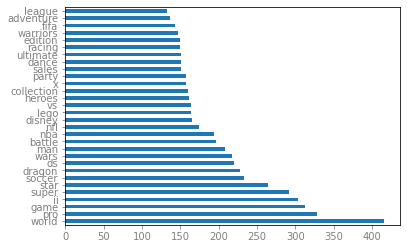

In [ ]:
pd.Series(words).value_counts().head(30).plot(kind='barh')

In [ ]:
from nltk.util import ngrams

def line_ngram(line, n=3):
  words = [w for w in line.split(' ') if len(w) != 0]
  return list(ngrams(words, n))

In [ ]:
name_grams = names.map(line_ngram)

In [ ]:
grams = [x for row in name_grams for x in row if len(x) > 0]

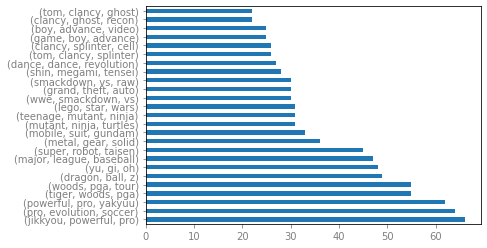

In [ ]:
pd.Series(grams).value_counts().head(25).plot(kind='barh')

In [ ]:
def clean_by_hero(x):
  custom_pipeline = [
                   preprocessing.fillna, 
                   preprocessing.lowercase,
                   preprocessing.remove_digits,
                   preprocessing.remove_punctuation,
                   preprocessing.remove_diacritics,
                   preprocessing.remove_whitespace,
                   preprocessing.remove_stopwords
                   ]
  return hero.clean(x, custom_pipeline)

def create_n_grams(x, n=3):
  x = clean_by_hero(x)
  x = pd.Series(x).map(lambda row:line_ngram(row, n=n))
  return x

class NameNGramBlock(BaseBlock):
  def __init__(self, whole_df, n=3):
    self.whole_df = whole_df
    self.n = n
  
  def fit(self, input_df, y=None):
    name_grams = create_n_grams(self.whole_df['Name'], n=self.n)
    grams = [x for row in name_grams for x in row if len(x) > 0]
    top_grams = pd.Series(grams).value_counts().head(10).index

    self.top_grams_ = top_grams
    return self.transform(input_df)

  def transform(self, input_df):
    name_grams = create_n_grams(input_df['Name'], n=self.n)
    output_df = pd.DataFrame()

    for gram in self.top_grams_:
      s_top = '-'.join(gram)
      output_df[f'{s_top}'] = name_grams.map(lambda row:gram in row).map(int)
    
    return output_df.add_prefix('Name_has_').add_suffix(f'_n={self.n}')

In [ ]:
block = NameNGramBlock(test_df, n=2)
block.fit(test_df).head()

,Name_has_madden-nfl_n=2,Name_has_need-speed_n=2,Name_has_tom-clancy_n=2,Name_has_pro-yakyuu_n=2,Name_has_jikkyou-powerful_n=2,Name_has_fifa-soccer_n=2,Name_has_powerful-pro_n=2,Name_has_spider-man_n=2,Name_has_pro-evolution_n=2,Name_has_call-duty_n=2
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [ ]:
block.transform(test_df).sum()

Name_has_madden-nfl_n=2          96
Name_has_need-speed_n=2          83
Name_has_tom-clancy_n=2          83
Name_has_pro-yakyuu_n=2          76
Name_has_jikkyou-powerful_n=2    70
Name_has_fifa-soccer_n=2         70
Name_has_powerful-pro_n=2        66
Name_has_spider-man_n=2          64
Name_has_pro-evolution_n=2       65
Name_has_call-duty_n=2           65
dtype: int64

### Sales Portfolio (Features only being in Train Data)

In [ ]:
sales_columns = train_df.columns[train_df.columns.str.contains('Sales')].tolist()
sales_columns = sorted(sales_columns)

In [ ]:
key = 'Genre'

input_df = train_df
_df = np.log1p(input_df[sales_columns].groupby(input_df[key]).sum())
# _df = (_df.T / _df.sum(axis=1)).T
_df

,EU_Sales,Global_Sales,JP_Sales,NA_Sales,Other_Sales
Genre,,,,,
Action,10.324957,11.574434,9.226804,10.896943,9.359708
Adventure,8.416931,9.719264,8.230577,8.885994,7.031741
Fighting,8.666992,10.213139,8.667164,9.496571,7.744137
Misc,9.503905,10.788122,8.962392,10.025218,8.434246
Platform,9.715590,11.172546,9.402200,10.548494,8.371242
Puzzle,8.261526,9.860267,8.411388,9.195227,6.826545
Racing,9.475777,10.698785,8.522579,9.987185,8.404248
Role-Playing,9.513182,11.185365,10.305179,10.097532,8.377701
Shooter,9.295692,10.669630,7.583248,10.189869,8.162516


In [ ]:
class SalesPortfolioBlock(BaseBlock):
  def __init__(self, key:str):
    self.key = key
    self.meta_df = None

  def fit(self, input_df):
    _df = np.log1p(input_df[sales_columns].groupby(input_df[self.key]).sum())
    _df = (_df.T /_df.sum(axis=1)).T
    self.meta_df = _df
    return self.transform(input_df)

  def transform(self, input_df):
    output_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
    return output_df.add_prefix(f'Sales@{self.key}_')

In [ ]:
score_columns = train_df.columns[train_df.columns.str.contains('Score')].tolist()
score_columns = sorted(score_columns)

class ScorePortfolioBlock(BaseBlock):
  def __init__(self, key:str):
    self.key = key
    self.meta_df = None

  def fit(self, input_df):
    _df = input_df[score_columns].groupby(input_df[self.key]).mean()

    self.meta_df = _df
    return self.transform(input_df)

  def transform(self, input_df):
    output_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
    return output_df.add_prefix(f'Score@{self.key}_')

In [ ]:
count_columns = train_df.columns[train_df.columns.str.contains('Count')].tolist()
count_columns = sorted(count_columns)

class CountPortfolioBlock(BaseBlock):
  def __init__(self, key:str):
    self.key = key
    self.meta_df = None

  def fit(self, input_df):
    _df = np.log1p(input_df[count_columns].groupby(input_df[self.key]).sum())
    _df = (_df.T /_df.sum(axis=1)).T
    self.meta_df = _df
    return self.transform(input_df)

  def transform(self, input_df):
    output_df = pd.merge(input_df[self.key], self.meta_df, on=self.key, how='left').drop(columns=[self.key])
    return output_df.add_prefix(f'Count@{self.key}_')

### Pivot, then PCA Features

In [ ]:
class PivotBlock(BaseBlock):
  def __init__(self,row, column, whole_df: pd.DataFrame):
    self.row = row
    self.column = column
    self.whole_df = whole_df

  def fit(self, input_df):
    _df = self.whole_df.pivot_table(index=self.row, columns=self.column, values='Name', aggfunc='count')
    _df = np.log1p(_df)
    self.meta_df = _df.add_prefix('_')

    return self.transform(input_df)

  def transform(self, input_df):
    output_df = pd.merge(input_df[self.row], 
                   self.meta_df, 
                   how='left', on=self.row).drop(columns=[self.row]).fillna(0)
    output_df = (output_df.T /output_df.sum(axis=1)).T

    return output_df.add_prefix(f'Pv@{self.row}_{self.column}_')

### Generating Training Data

In [ ]:
class WrapperBlock(BaseBlock):
  def __init__(self, function):
    self.function = function
  
  def transform(self, input_df):
    return self.function(input_df)

In [ ]:
process_blocks = [
    WrapperBlock(create_continuous_features),
    NameNGramBlock(whole_df, n=2),
    NameNGramBlock(whole_df, n=3),

    create_boolean_features(column='Platform', texts=['pc']),
    create_boolean_features(column='Publisher', texts=['nintendo']),
    create_boolean_features(column='Developer', texts=['ea', 'japan', 'ubisoft', 'nintendo', 'bandai']),
    create_boolean_features(column='Rating', texts=['E']),
    # *[OneHotBlock(c) for c in ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating']],
    
    *[SalesPortfolioBlock(c) for c in ['Genre', 'Platform', 'Year_of_Release', 'Rating']],
    *[ScorePortfolioBlock(c) for c in ['Genre', 'Platform', 'Year_of_Release', 'Rating']],
    *[CountPortfolioBlock(c) for c in ['Name', 'Genre', 'Platform', 'Year_of_Release', 'Rating']],

    *[CountEncodingBlock(c, whole_df=whole_df) for c in ['Name', 'Platform', 'Publisher', 'Year_of_Release', 'Rating']],
    *[PivotBlock(row='Publisher', column=c, whole_df=whole_df) for c in ['Platform', 'Genre', 'Year_of_Release', 'Developer', 'Rating']],
    *[PivotBlock(row='Developer', column=c, whole_df=whole_df) for c in ['Platform', 'Genre', 'Year_of_Release', 'Rating']],
    *[PivotBlock(row='Genre', column=c, whole_df=whole_df) for c in ['Platform', 'Publisher', 'Developer', 'Year_of_Release', 'Rating']],
    *[PivotBlock(row='Platform', column=c, whole_df=whole_df) for c in ['Genre', 'Publisher', 'Developer', 'Year_of_Release', 'Rating']],
     *[PivotBlock(row='Year_of_Release', column=c, whole_df=whole_df) for c in ['Genre', 'Publisher', 'Developer', 'Rating']],
]

In [ ]:
from contextlib import contextmanager
from time import time

@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
  if prefix: format_str = str(prefix) + format_str
  if suffix: format_str = format_str + str(suffix)
  start = time()
  yield
  d = time() - start
  output_str = format_str.format(d)
  if logger:
    logger.info(output_str)
  else:
    print(output_str)

In [ ]:
from tqdm import tqdm

def get_function(block, is_train):
  s = mapping = {
      True: 'fit',
      False: 'transform'
  }.get(is_train)
  return getattr(block, s)

def to_features(input_df, blocks, is_train=False):
  output_df = pd.DataFrame()

  for block in tqdm(blocks, total=len(blocks)):
    func = get_function(block, is_train)

    with timer(prefix='create ' + func.__name__ + ' '):
      _df = func(input_df)

    assert len(_df) == len(input_df), func.__name__
    output_df = pd.concat([output_df, _df], axis=1)

  return output_df

In [ ]:
train_feat_df = to_features(train_df, process_blocks, is_train=True)
test_feat_df = to_features(test_df, process_blocks)

  0%|          | 0/48 [00:00<?, ?it/s]

create fit 0.013[s]


  4%|▍         | 2/48 [00:00<00:22,  2.08it/s]

create fit 0.942[s]


 17%|█▋        | 8/48 [00:01<00:13,  2.90it/s]

create fit 0.486[s]
create fit 0.012[s]
create fit 0.010[s]
create fit 0.043[s]
create fit 0.009[s]
create fit 0.010[s]
create fit 0.013[s]
create fit 0.010[s]
create fit 0.010[s]
create fit 0.007[s]
create fit 0.007[s]
create fit 0.008[s]


 44%|████▍     | 21/48 [00:01<00:04,  5.65it/s]

create fit 0.011[s]
create fit 0.021[s]
create fit 0.009[s]
create fit 0.009[s]
create fit 0.009[s]
create fit 0.009[s]
create fit 0.011[s]
create fit 0.006[s]
create fit 0.005[s]
create fit 0.004[s]
create fit 0.005[s]
create fit 0.029[s]


 56%|█████▋    | 27/48 [00:01<00:02,  7.68it/s]

create fit 0.027[s]
create fit 0.032[s]
create fit 0.619[s]
create fit 0.028[s]
create fit 0.035[s]
create fit 0.030[s]


 67%|██████▋   | 32/48 [00:03<00:02,  6.08it/s]

create fit 0.037[s]
create fit 0.027[s]
create fit 0.033[s]


 75%|███████▌  | 36/48 [00:03<00:02,  5.50it/s]

create fit 0.249[s]
create fit 0.464[s]
create fit 0.028[s]
create fit 0.024[s]


 81%|████████▏ | 39/48 [00:05<00:02,  3.31it/s]

create fit 0.027[s]
create fit 0.149[s]


 85%|████████▌ | 41/48 [00:06<00:02,  2.99it/s]

create fit 0.473[s]
create fit 0.030[s]


 90%|████████▉ | 43/48 [00:08<00:02,  2.20it/s]

create fit 0.025[s]


 92%|█████████▏| 44/48 [00:09<00:02,  1.55it/s]

create fit 0.028[s]


 94%|█████████▍| 45/48 [00:10<00:02,  1.34it/s]

create fit 0.156[s]


 96%|█████████▌| 46/48 [00:10<00:01,  1.44it/s]

create fit 0.542[s]


 98%|█████████▊| 47/48 [00:12<00:00,  1.02it/s]

create fit 0.028[s]


  0%|          | 0/48 [00:00<?, ?it/s]

create transform 0.008[s]


  4%|▍         | 2/48 [00:00<00:05,  8.84it/s]

create transform 0.215[s]


 17%|█▋        | 8/48 [00:00<00:04,  9.17it/s]

create transform 0.221[s]
create transform 0.013[s]
create transform 0.011[s]
create transform 0.042[s]
create transform 0.010[s]
create transform 0.005[s]
create transform 0.006[s]
create transform 0.005[s]
create transform 0.005[s]
create transform 0.004[s]
create transform 0.004[s]
create transform 0.005[s]
create transform 0.004[s]
create transform 0.007[s]
create transform 0.005[s]
create transform 0.004[s]


 54%|█████▍    | 26/48 [00:00<00:01, 16.70it/s]

create transform 0.007[s]
create transform 0.007[s]
create transform 0.011[s]
create transform 0.005[s]
create transform 0.005[s]
create transform 0.004[s]
create transform 0.006[s]
create transform 0.015[s]
create transform 0.012[s]
create transform 0.014[s]
create transform 0.411[s]
create transform 0.015[s]
create transform 0.016[s]
create transform 0.011[s]


 67%|██████▋   | 32/48 [00:01<00:01, 10.99it/s]

create transform 0.017[s]
create transform 0.010[s]
create transform 0.013[s]


 75%|███████▌  | 36/48 [00:02<00:01,  8.25it/s]

create transform 0.145[s]
create transform 0.471[s]
create transform 0.016[s]
create transform 0.009[s]


 81%|████████▏ | 39/48 [00:03<00:01,  4.56it/s]

create transform 0.012[s]
create transform 0.117[s]


 85%|████████▌ | 41/48 [00:04<00:01,  3.73it/s]

create transform 0.493[s]
create transform 0.015[s]


 90%|████████▉ | 43/48 [00:05<00:01,  2.55it/s]

create transform 0.009[s]
create transform 0.010[s]


 94%|█████████▍| 45/48 [00:06<00:01,  2.35it/s]

create transform 0.151[s]


 96%|█████████▌| 46/48 [00:07<00:00,  2.17it/s]

create transform 0.501[s]


 98%|█████████▊| 47/48 [00:08<00:00,  1.63it/s]

create transform 0.015[s]


100%|██████████| 48/48 [00:09<00:00,  5.11it/s]


In [ ]:
test_feat_df.head().T

,0,1,2,3,4
Critic_Score,84.0,91.0,87.0,70.0,71.0
Critic_Count,23.0,17.0,28.0,54.0,41.0
User_Score,8.0,9.0,8.5,6.9,6.9
User_Count,19.0,132.0,39.0,180.0,143.0
Year_of_Release,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
Pv@Year_of_Release_Rating__EC,NaN,NaN,NaN,NaN,NaN
Pv@Year_of_Release_Rating__K-A,NaN,NaN,NaN,NaN,NaN
Pv@Year_of_Release_Rating__M,NaN,NaN,NaN,NaN,NaN
Pv@Year_of_Release_Rating__RP,NaN,NaN,NaN,NaN,NaN


In [ ]:
assert len(test_feat_df) == len(test_df)

## Train LGBM

In [ ]:
import lightgbm as lgb
# import optuna.integration.lightgbm as lgb
from sklearn.metrics import mean_squared_log_error as MSLE

In [ ]:
def fit_lgb(X, y, cv, params: dict=None, verbose: int=50):
  if params is None:
    params = {}

  models = []
  y_d = np.log1p(y)
  oof_pred = np.zeros_like(y_d, dtype=np.float)

  for i, (train_idx, valid_idx) in enumerate(cv):
    train_data = lgb.Dataset(data=X[train_idx], label=y_d[train_idx])
    valid_data = lgb.Dataset(data=X[valid_idx], label=y_d[valid_idx], reference=train_data)

    with timer(prefix=f'fit fold={i+1}'):
      model = lgb.train(
          params=params, 
          train_set=train_data, 
          valid_sets=[train_data, valid_data], 
          valid_names=['Train', 'Valid'],
          num_boost_round = 10_000,
          early_stopping_rounds=verbose,
          verbose_eval=verbose
          )
    
    pred_i_d = model.predict(X[valid_idx])
    pred_i = np.expm1(pred_i_d)
    pred_i = np.where(pred_i < 0, 0, pred_i)
    oof_pred[valid_idx] = pred_i
    models.append(model)

    print(f'Fold {i+1} RMSLE: {MSLE(y[valid_idx], pred_i)**.5:.4f}')

  score = MSLE(y, oof_pred) ** .5
  print(f'FINISHED | Whole RMSLE: {score:.4f}')
  return oof_pred, models

In [ ]:
lgb_params = {
    'objective': 'regression',
    'metrics': 'rmse',
    'learning_rate': .1,
    'max_depth': 8,
    'n_estimators': 10_000,
    'colsample_bytree': .5, 
    'num_threads': 8,
    'force_col_wise': True,
    'verbose': -1,
}

y = train_df['Global_Sales'].values

In [ ]:
lgb_models = {}
lgb_oof_pred = {}

#### CV by Groups

In [ ]:
def split_by_groups(groups):
  kfold = KFold(n_splits=5, random_state=89, shuffle=True)
  groups = pd.Series(groups)
  unique_groups = groups.unique()
  splits = []

  def _filter_idxs(idx):
    values = unique_groups[idx]
    idx = groups.isin(values)
    return groups[idx].index.values

  for idx_tr, idx_val in kfold.split(unique_groups):
    splits.append([
                   _filter_idxs(idx_tr), _filter_idxs(idx_val)
    ])

  return splits

In [ ]:
cv = split_by_groups(train_df['Publisher'])
lgb_oof_pred['grouped'], lgb_models['grouped'] = fit_lgb(train_feat_df.values, y, cv, params=lgb_params)

Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.725872	Valid's rmse: 1.24579
[100]	Train's rmse: 0.653032	Valid's rmse: 1.24091
[150]	Train's rmse: 0.609638	Valid's rmse: 1.23495
Early stopping, best iteration is:
[113]	Train's rmse: 0.639424	Valid's rmse: 1.22887
fit fold=137.777[s]
Fold 1 RMSLE: 1.2289


Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.767686	Valid's rmse: 0.989177
[100]	Train's rmse: 0.694938	Valid's rmse: 0.976967
[150]	Train's rmse: 0.654192	Valid's rmse: 0.971627
[200]	Train's rmse: 0.616708	Valid's rmse: 0.972904
Early stopping, best iteration is:
[190]	Train's rmse: 0.620924	Valid's rmse: 0.970145
fit fold=247.714[s]
Fold 2 RMSLE: 0.9701


Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.753866	Valid's rmse: 1.03132
[100]	Train's rmse: 0.6802	Valid's rmse: 1.01405
[150]	Train's rmse: 0.639192	Valid's rmse: 1.01309
Early stopping, best iteration is:
[132]	Train's rmse: 0.65123	Valid's rmse: 1.01091
fit fold=339.406[s]
Fold 3 RMSLE: 1.0109


Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.75089	Valid's rmse: 0.945138
[100]	Train's rmse: 0.677121	Valid's rmse: 0.945093
Early stopping, best iteration is:
[87]	Train's rmse: 0.691962	Valid's rmse: 0.942904
fit fold=434.178[s]
Fold 4 RMSLE: 0.9429


Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.718543	Valid's rmse: 1.06861
[100]	Train's rmse: 0.642446	Valid's rmse: 1.05871
[150]	Train's rmse: 0.596252	Valid's rmse: 1.05646
Early stopping, best iteration is:
[122]	Train's rmse: 0.618245	Valid's rmse: 1.05559
fit fold=538.395[s]
Fold 5 RMSLE: 1.0556
FINISHED | Whole RMSLE: 1.0477


#### Stratified K Fold on Global Sales Bins

In [ ]:
def create_folds(input_df, y):
  num_bins = np.int(1 + np.log2(len(y)))
  bins = pd.cut(
      y,
      bins=num_bins,
      labels=False
  )

  kfold = StratifiedKFold(n_splits=5)
  fold_idxs = list(kfold.split(X=input_df, y=bins))
  return fold_idxs

In [ ]:
cv = create_folds(train_feat_df.values, y)
lgb_oof_pred['binned'], lgb_models['binned'] = fit_lgb(train_feat_df.values, y, cv, params=lgb_params)

The least populated class in y has only 1 members, which is less than n_splits=5.
Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.71988	Valid's rmse: 1.22911
[100]	Train's rmse: 0.644334	Valid's rmse: 1.23929
Early stopping, best iteration is:
[52]	Train's rmse: 0.715335	Valid's rmse: 1.2288
fit fold=116.028[s]
Fold 1 RMSLE: 1.2288


Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.753212	Valid's rmse: 0.966271
[100]	Train's rmse: 0.678663	Valid's rmse: 0.97981
Early stopping, best iteration is:
[72]	Train's rmse: 0.716173	Valid's rmse: 0.965044
fit fold=219.099[s]
Fold 2 RMSLE: 0.9650


Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.749713	Valid's rmse: 0.945376
[100]	Train's rmse: 0.673557	Valid's rmse: 0.932841
[150]	Train's rmse: 0.624256	Valid's rmse: 0.932378
Early stopping, best iteration is:
[146]	Train's rmse: 0.628241	Valid's rmse: 0.931479
fit fold=327.113[s]
Fold 3 RMSLE: 0.9315


Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.771647	Valid's rmse: 0.840134
[100]	Train's rmse: 0.695191	Valid's rmse: 0.838364
Early stopping, best iteration is:
[73]	Train's rmse: 0.728868	Valid's rmse: 0.836747
fit fold=419.350[s]
Fold 4 RMSLE: 0.8367


Found `n_estimators` in params. Will use it instead of argument


Training until validation scores don't improve for 50 rounds.
[50]	Train's rmse: 0.766539	Valid's rmse: 0.991122
[100]	Train's rmse: 0.695457	Valid's rmse: 0.978699
[150]	Train's rmse: 0.648288	Valid's rmse: 0.978078
Early stopping, best iteration is:
[113]	Train's rmse: 0.682551	Valid's rmse: 0.975865
fit fold=523.316[s]
Fold 5 RMSLE: 0.9759
FINISHED | Whole RMSLE: 0.9961


## Train CatBoost

In [ ]:
!pip install catboost
clear_output()

In [ ]:
from catboost import CatBoost as cat

In [ ]:
def fit_catboost(X, y, cv, params: dict=None, verbose: int=50):
  if params is None:
    params = {}

  models = []
  y_d = np.log1p(y)
  oof_pred = np.zeros_like(y_d, dtype=np.float)

  for i, (train_idx, valid_idx) in enumerate(cv):
    train_data = lgb.Dataset(data=X[train_idx], label=y_d[train_idx])
    valid_data = lgb.Dataset(data=X[valid_idx], label=y_d[valid_idx], reference=train_data)

    with timer(prefix=f'fit fold={i+1}'):
      model = cat(params=params).fit(
          X=X[train_idx], y=y_d[train_idx],
          eval_set=[(X[valid_idx], y_d[valid_idx])],
          early_stopping_rounds=verbose,
          verbose_eval=verbose
      )
    
    pred_i_d = model.predict(X[valid_idx])
    pred_i = np.expm1(pred_i_d)
    pred_i = np.where(pred_i < 0, 0, pred_i)
    oof_pred[valid_idx] = pred_i
    models.append(model)

    print(f'Fold {i+1} RMSLE: {MSLE(y[valid_idx], pred_i)**.5:.4f}')

  score = MSLE(y, oof_pred) ** .5
  print(f'FINISHED | Whole RMSLE: {score:.4f}')
  return oof_pred, models

In [ ]:
cat_params = {
    'loss_function':'RMSE',
    'iterations':2_000, 
    'learning_rate':.1, 
    'depth':8,
    'colsample_bylevel':.5,
}

y = train_df['Global_Sales'].values

In [ ]:
cat_models = {}
cat_oof_pred = {}

### CV by Groups

In [ ]:
cv = split_by_groups(train_df['Publisher'])
cat_oof_pred['grouped'], cat_models['grouped'] = fit_catboost(train_feat_df.values, y, cv, params=cat_params)

0:	learn: 1.3458171	test: 1.3611428	best: 1.3611428 (0)	total: 448ms	remaining: 14m 55s
50:	learn: 0.8944441	test: 0.8984810	best: 0.8984810 (50)	total: 18.2s	remaining: 11m 34s
100:	learn: 0.8222474	test: 0.8703463	best: 0.8703463 (100)	total: 35.5s	remaining: 11m 7s
150:	learn: 0.7549692	test: 0.8555860	best: 0.8555860 (150)	total: 53.2s	remaining: 10m 51s
200:	learn: 0.7126416	test: 0.8475026	best: 0.8469803 (199)	total: 1m 10s	remaining: 10m 34s
250:	learn: 0.6786575	test: 0.8491183	best: 0.8456209 (206)	total: 1m 28s	remaining: 10m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8456208809
bestIteration = 206

Shrink model to first 207 iterations.
fit fold=1103.703[s]
Fold 1 RMSLE: 0.8456
0:	learn: 1.2701760	test: 1.7261776	best: 1.7261776 (0)	total: 371ms	remaining: 12m 22s
50:	learn: 0.8613969	test: 1.4167662	best: 1.4165436 (49)	total: 17.7s	remaining: 11m 15s
100:	learn: 0.7923920	test: 1.3875720	best: 1.3875720 (100)	total: 34.5s	remaining: 10m 48s
150

### Stratified K Fold on Global Sales Bins

In [ ]:
cv = create_folds(train_feat_df.values, y)
cat_oof_pred['binned'], cat_models['binned'] = fit_catboost(train_feat_df.values, y, cv, params=cat_params)

The least populated class in y has only 1 members, which is less than n_splits=10.


0:	learn: 1.3347389	test: 1.4212111	best: 1.4212111 (0)	total: 653ms	remaining: 21m 44s
50:	learn: 0.8796296	test: 1.2024137	best: 1.1458357 (31)	total: 18.6s	remaining: 11m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.145835722
bestIteration = 31

Shrink model to first 32 iterations.
fit fold=143.095[s]
Fold 1 RMSLE: 1.1458
0:	learn: 1.3446252	test: 1.3810002	best: 1.3810002 (0)	total: 342ms	remaining: 11m 24s
50:	learn: 0.8787236	test: 1.0769400	best: 1.0769400 (50)	total: 17.5s	remaining: 11m 7s
100:	learn: 0.8082747	test: 1.0520346	best: 1.0520346 (100)	total: 34.5s	remaining: 10m 49s
150:	learn: 0.7439673	test: 1.0383584	best: 1.0377408 (137)	total: 51.5s	remaining: 10m 30s
200:	learn: 0.7080284	test: 1.0388443	best: 1.0352893 (186)	total: 1m 8s	remaining: 10m 10s
250:	learn: 0.6705614	test: 1.0360973	best: 1.0346601 (230)	total: 1m 25s	remaining: 9m 54s
300:	learn: 0.6385102	test: 1.0328794	best: 1.0324830 (288)	total: 1m 42s	remaining: 9m 37s
Stopped b

## Note

### Feature Importance



In [ ]:
!pip install shap
clear_output()

import shap

In [ ]:
shap_values = np.zeros(test_feat_df.shape)

for i in range(len(lgb_models['grouped'])):
  shap_values += shap.TreeExplainer(lgb_models['grouped'][i]).shap_values(test_feat_df)

shap_values /= len(lgb_models['grouped'])

shap.summary_plot(shap_values, test_feat_df)

In [ ]:
shap_values = np.zeros(test_feat_df.shape)

for i in range(len(lgb_models['binned'])):
  shap_values += shap.TreeExplainer(lgb_models['binned'][i]).shap_values(test_feat_df)

shap_values /= len(lgb_models['binned'])

shap.summary_plot(shap_values, test_feat_df)

In [ ]:
shap_values = np.zeros(test_feat_df.shape)

for i in range(len(cat_models['grouped'])):
  shap_values += shap.TreeExplainer(cat_models['grouped'][i]).shap_values(test_feat_df)

shap_values /= len(cat_models['grouped'])

shap.summary_plot(shap_values, test_feat_df)

In [ ]:
shap_values = np.zeros(test_feat_df.shape)

for i in range(len(cat_models['binned'])):
  shap_values += shap.TreeExplainer(cat_models['binned'][i]).shap_values(test_feat_df)

shap_values /= len(cat_models['binned'])

shap.summary_plot(shap_values, test_feat_df)

In [1]:
def visualize_importance(models, feat_train_df, importance_type='gain'):
  feature_importance_df = pd.DataFrame()

  for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type)
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1

    feature_importance_df = pd.concat([feature_importance_df,
                                       _df], axis=0, ignore_index=True)
    
  order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

  fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
  sns.boxenplot(data=feature_importance_df, 
                y='column', 
                x='feature_importance',
                order=order,
                ax=ax,
                orient='h',
                palette='viridis')
  ax.tick_params(axis='x', rotation=90)
  ax.grid(True)
  fig.tight_layout()
  return fig, ax

In [2]:
fig, ax = visualize_importance(lgb_models['grouped'], train_feat_df)

NameError: ignored

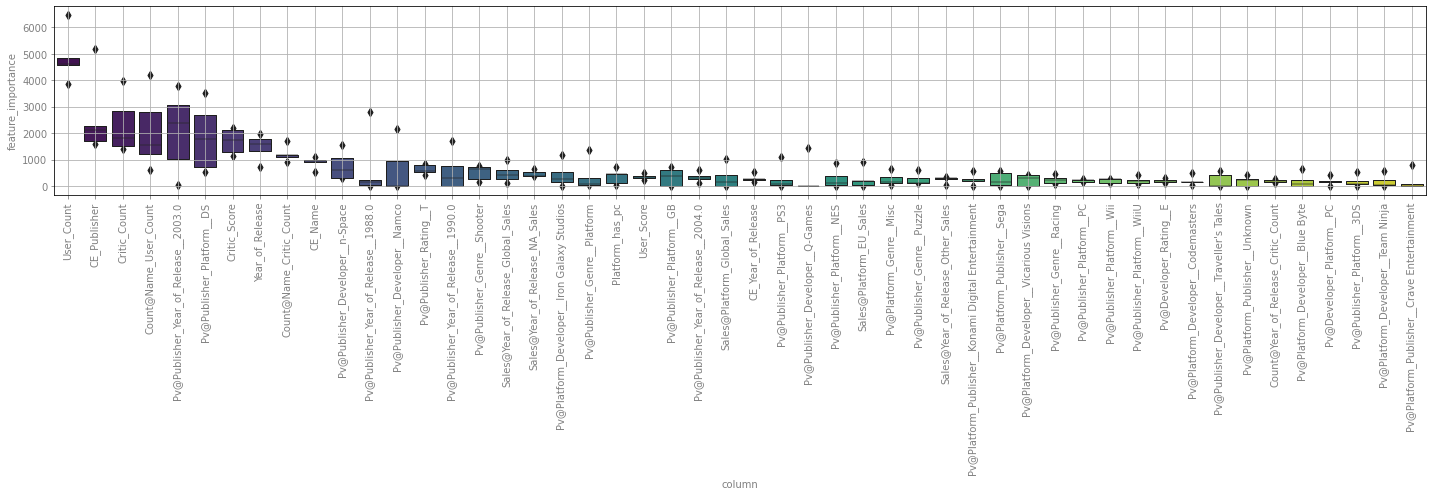

In [ ]:
fig, ax = visualize_importance(lgb_models['binned'], train_feat_df)

## Submission

### CV

In [ ]:
score = MSLE(y, (lgb_oof_pred['grouped']+lgb_oof_pred['binned'])/2) ** .5
print(f'FINISHED | Whole RMSLE: {score:.4f}')

FINISHED | Whole RMSLE: 0.9566


In [ ]:
pred = np.array([model.predict(test_feat_df.values) for model in lgb_models['grouped'] + lgb_models['binned']])
pred = np.expm1(pred)
pred = np.mean(pred, axis=0)
pred = np.where(pred < 0, 0, pred)
sub_df = pd.DataFrame({ 'Global_Sales': pred })
sub_df.to_csv('submission.csv', index=False)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


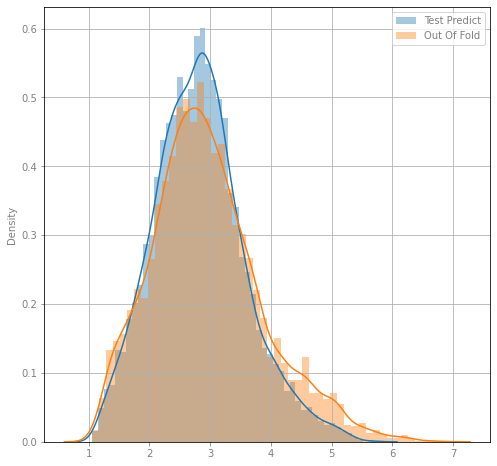

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred), label='Test Predict')
sns.distplot((np.log1p(lgb_oof_pred['grouped']) + np.log1p(lgb_oof_pred['binned']))/2, label='Out Of Fold')
ax.legend()
ax.grid()

### Stacking

In [ ]:
from sklearn.linear_model import ElasticNet
from lightgbm import LGBMRegressor

In [ ]:
lv_1_train_pred = np.array([model.predict(train_feat_df.values) for model in\
                            lgb_models['grouped'] + cat_models['grouped'] + lgb_models['binned'] + cat_models['binned']]).T
lv_1_test_pred = np.array([model.predict(test_feat_df.values) for model in\
                           lgb_models['grouped'] + cat_models['grouped'] + lgb_models['binned'] + cat_models['binned']]).T

meta_regressor = ElasticNet().fit(lv_1_train_pred, np.log1p(y))

In [ ]:
lv_2_test_pred = meta_regressor.predict(lv_1_test_pred)
lv_2_test_pred = np.expm1(lv_2_test_pred)
lv_2_test_pred = np.where(lv_2_test_pred < 0, 0, lv_2_test_pred)

In [ ]:
sub_df = pd.DataFrame({ 'Global_Sales': lv_2_test_pred })
sub_df.to_csv('submission.csv', index=False)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


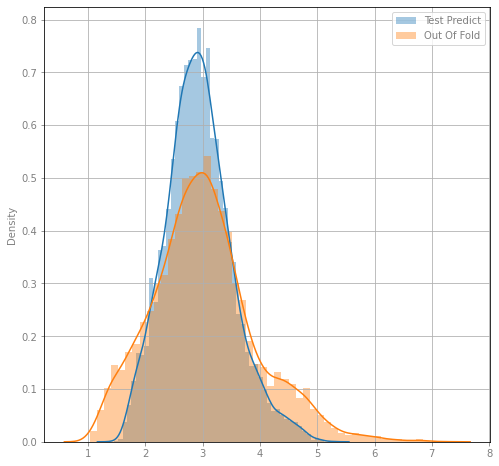

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(lv_2_test_pred), label='Test Predict')
sns.distplot(np.log1p(
    (lgb_oof_pred['grouped'] + cat_oof_pred['grouped'] + lgb_oof_pred['binned'] + cat_oof_pred['binned'])/4), label='Out Of Fold')
ax.legend()
ax.grid()

### CV Blending

In [ ]:
meta_regressor =  LGBMRegressor(importance_type='gain')

In [ ]:
meta_regressor.fit(
    X=pd.concat([train_feat_df, 
                 pd.DataFrame(np.log1p(lgb_oof_pred['grouped']), columns=['lv1_lgb_train_pred']),
                 pd.DataFrame(np.log1p(cat_oof_pred['grouped']), columns=['lv1_cat_train_pred'])
                ], axis=1),
    y=np.log1p(y)
)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='gain', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [ ]:
lgb_pred = np.mean([model.predict(test_feat_df.values) for model in lgb_models['grouped']], axis=0)
cat_pred = np.mean([model.predict(test_feat_df.values) for model in cat_models['grouped']], axis=0)

In [ ]:
lv2_test_pred = meta_regressor.predict(
    pd.concat([test_feat_df,
               pd.DataFrame(lgb_pred, columns=['lv1_lgb_test_pred']),
              #  pd.DataFrame(cat_pred, columns=['lv1_cat_test_pred'])
    ], axis=1))

lv_2_test_pred = np.expm1(lv_2_test_pred)
lv_2_test_pred = np.where(lv_2_test_pred < 0, 0, lv_2_test_pred)

In [ ]:
sub_df = pd.DataFrame({ 'Global_Sales': lv_2_test_pred })
sub_df.to_csv('submission.csv', index=False)

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


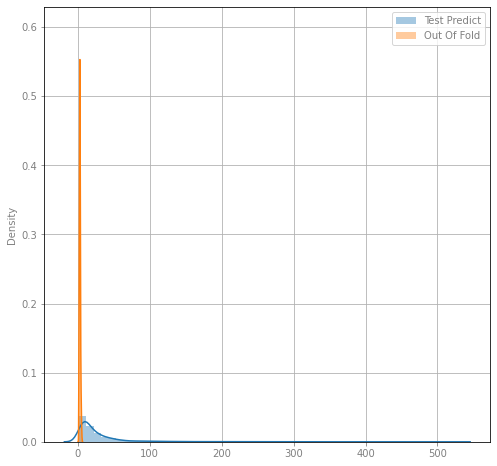

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(lv_2_test_pred), label='Test Predict')
sns.distplot(np.log1p(lgb_oof_pred['grouped']), label='Out Of Fold')
ax.legend()
ax.grid()